# 사용 패키지

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!apt-get update
!apt-get install g++ openjdk-8-jdk 
!pip3 install konlpy JPype1-py3
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [ ]:
!pip install transformers datasets rouge_score kobart_transformers

In [4]:
import pandas as pd
import numpy as np
import json
import os
from tqdm import tqdm
import gc
import matplotlib.pyplot as plt

from konlpy.tag import Mecab

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader,TensorDataset

from datasets import load_metric
from kobart_transformers import get_kobart_model, get_kobart_for_conditional_generation, get_kobart_tokenizer
from transformers import BartForConditionalGeneration

## hyperparameter

In [5]:
batch_size = 16
learning_rate = 1e-4
epochs = 1

device = torch.device("cuda:0")

## define metric

In [6]:
metric = load_metric("rouge")

Downloading:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

In [7]:
def rouge_function(labels,summary_ids,tar_tokenizer):
    
    pred_list = [tar_tokenizer.convert_tokens_to_string(tar_tokenizer.convert_ids_to_tokens(g.to('cpu').tolist())) for g in summary_ids]

    real_list = [tar_tokenizer.convert_tokens_to_string(tar_tokenizer.convert_ids_to_tokens(g.to('cpu').tolist())) for g in labels]

    result = metric.compute(predictions=pred_list,references=real_list)

    metric_result = {key:value.mid.fmeasure for key,value in result.items()}

    return metric_result['rouge1'],metric_result['rouge2'],metric_result['rougeL']

## load train data

In [8]:
DIR = "/content/drive/MyDrive/data/"
TRAIN_SOURCE = os.path.join(DIR, "train_original.json")
VALID_SOURCE = os.path.join(DIR, "vaild_original.json")

In [9]:
with open(TRAIN_SOURCE) as f:
    TRAIN_DATA = json.loads(f.read())
    
with open(VALID_SOURCE) as f:
    VALID_DATA = json.loads(f.read())

## create train data

In [10]:
train = pd.DataFrame(columns=['id', 'context', 'extractive', 'summary'])

train_document = TRAIN_DATA['documents']

id = 0

for data in tqdm(train_document):
    
    abstractive, extractive, texts = data['abstractive'], data['extractive'], data['text']

    context = ''

    extract_context = ''

    for text in texts[0]:
        context += text['sentence']

        if text['index'] in extractive:
            extract_context += text['sentence']
    

    train.loc[id, 'id'] = id
    train.loc[id, 'context'] = context
    train.loc[id, 'extractive'] = extract_context
    train.loc[id, 'summary'] = abstractive[0]

    id += 1

100%|██████████| 27033/27033 [01:10<00:00, 385.94it/s]


In [ ]:
train.head()

,id,context,extractive,summary
0,0,원고가 소속회사의 노동조합에서 분규가 발생하자 노조활동을 구실로 정상적인 근무를 해...,노동조합규약에 동 조합장의 직무를 대행할 자를 규정해 두고 있음에도 원고 자신이 주...,원고가 주동하여 회사업무능률을 저해하고 회사업무상의 지휘명령에 위반하였다면 이에 ...
1,1,수출입업체인 원고가 의류제품을 제조ㆍ수출함에 있어 같은 그룹내 종합무역상사인 소외 ...,수출입업체인 원고가 의류제품을 제조ㆍ수출함에 있어 같은 그룹내 종합무역상사인 소외 ...,수출입업체인 원고가 의류제품을 제조ㆍ수출함에 있어 소외 회사의 직수출실적을 지원하기...
2,2,가등기담보권자가 제소전 화해조항에 따라 자기 명의로 소유권이전의 본등기를 경료한 후...,가등기담보권자가 제소전 화해조항에 따라 자기 명의로 소유권이전의 본등기를 경료한 후...,가등기담보권자가 제소전 화해조항에 의해 자기 명의로 소유권이전의 본등기를 경료하고 ...
3,3,가. 부가가치세법 제22조 제3항 단서에 제1호와 제2호가 동시에 해당한다는 뜻은 ...,제19조의 확정신고와 확정납부끼리 동시에 해당하는 경우를 말하는 것이지 제18조의 ...,부가가치세법 제22조 제3항 단서에 제1호와 제2호가 동시에 해당한다는 의미는 제1...
4,4,소득세법 제116조 제1항의 규정에 의하면정부는 과세표준확정신고를 하여야 할 자에 ...,정부는 과세표준확정신고를 하여야 할 자에 대하여 당해년도의 과세표준과 세액을 다음 ...,소득세법 제116조 제1항에 따르면 정부는 과세표준확정신고를 해야 할 자에 대해 당...


In [ ]:
train['summary'][0]

'원고가  주동하여 회사업무능률을 저해하고 회사업무상의 지휘명령에 위반하였다면 이에 따른 징계해고는 사내질서를 유지하기 위한 사용자 고유의 정당한 징계권의 행사로 보아야 한다.'

In [11]:
valid = pd.DataFrame(columns=['id', 'context', 'extractive', 'summary'])

valid_document = VALID_DATA['documents']

id = 0

for data in tqdm(valid_document):
    
    abstractive, extractive, texts = data['abstractive'], data['extractive'], data['text']

    context = ''

    extract_context = ''

    for text in texts[0]:
        
        if text['sentence'][0] == '[':
            sentence = text['sentence'][4:]
        
        else:
            sentence = text['sentence']

        context += sentence

        if text['index'] in extractive:
            extract_context += sentence
    

    valid.loc[id, 'id'] = id
    valid.loc[id, 'context'] = context
    valid.loc[id, 'extractive'] = extract_context
    valid.loc[id, 'summary'] = abstractive[0]

    id += 1

100%|██████████| 3004/3004 [00:03<00:00, 784.29it/s]


In [ ]:
valid.head()

,id,context,extractive,summary
0,0,"취소소송은 처분 등이 있음을 안 날부터 90일 이내에 제기하여야 하고,처분 등이 있...","취소소송은 처분 등이 있음을 안 날부터 90일 이내에 제기하여야 하고,","취소소송은 처분 등이 있다는 것을 안 때로부터 90일 이내에 제기하여야 하고, 행정..."
1,1,항고소송의 대상이 되는 행정처분이라 함은 원칙적으로 행정청의 공법상 행위로서 특정 ...,항고소송의 대상이 되는 행정처분이라 함은 원칙적으로 행정청의 공법상 행위로서 특정 ...,항고소송의 대상이 되는 행정처분이란 일반 국민의 권리의무에 직접 영향을 미치는 행위...
2,2,취득세는 본래 재화의 이전이라는 사실 자체를 포착하여 거기에 담세력을 인정하고부과하...,부과하는 유통세의 일종으로 취득자가 재화를 사용·수익·처분함으로써 얻을 수 있는 이...,"취득세는 사실상의 취득행위 자체를 과세객체로 하고, 지방세법에 따르면 부동산 취득에..."
3,3,행정처분이 당연무효라고 하기 위하여는 처분에 위법사유가 있다는 것만으로는 부족하고하...,행정처분이 당연무효라고 하기 위하여는 처분에 위법사유가 있다는 것만으로는 부족하고하...,"행정처분이 당연무효라고 하기 위해서는 하자가 중대, 명백해야 하는데 세관출장소장이 ..."
4,4,등록출원한 상표가 상표법 제6조 제1항 제6호의 '간단하고 흔히 있는 표장만으로 된...,등록출원한 상표가 상표법 제6조 제1항 제6호의 '간단하고 흔히 있는 표장만으로 된...,"상표법에 따라 상표가 등록받을 수 있는지의 여부는 구체적으로 판단하므로 출원상표 ""..."


In [ ]:
train.shape , valid.shape

((27033, 4), (3004, 4))

## tokenizing using kobart

In [12]:
kobart_tokenizer = get_kobart_tokenizer()

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/109 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/666k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BartTokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [13]:
train_src = kobart_tokenizer(list(train.context), padding=True, truncation=True, max_length=500)
val_src = kobart_tokenizer(list(valid.context), padding=True, truncation=True, max_length=500)

train_tar = kobart_tokenizer(list(train.summary), padding=True, truncation=True, max_length=50)
val_tar = kobart_tokenizer(list(valid.summary), padding=True, truncation=True, max_length=50)

In [ ]:
len(train_src['input_ids'])

27033

## create torch dataset

In [14]:
class CustomDataset(Dataset):
    def __init__(self, src_tokens, tar_tokens, mode='train'):
        self.mode = mode
        self.src_tokens = src_tokens
        if self.mode == 'train':
            self.tar_tokens = tar_tokens
            
    def __len__(self):
        return len(self.src_tokens)
    
    def __getitem__(self, i):
        src_token = self.src_tokens[i]
        if self.mode == 'train':
            tar_token = self.tar_tokens[i]
            return {
                'src_token' : torch.tensor(src_token, dtype=torch.long),
                'tar_token' : torch.tensor(tar_token, dtype=torch.long),
            }
        else:
            return {
                'src_token' : torch.tensor(src_token, dtype=torch.long)
            }

In [15]:
train_dataset = CustomDataset(train_src['input_ids'], train_tar['input_ids'])
val_dataset = CustomDataset(val_src['input_ids'], val_tar['input_ids'])

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=2, shuffle=False)

## load kobart model

In [ ]:
model = get_kobart_for_conditional_generation()

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## model train

In [16]:
# load trained model

model = BartForConditionalGeneration.from_pretrained('/content/drive/MyDrive/data/model.pt')

In [18]:
def train_step(model, batch_item, batch, training):
    input_ids = batch_item['src_token'].to(device)
    labels = batch_item['tar_token'].to(device)

    inputs = {'input_ids':input_ids,
                       'labels':labels}
  
    model.to(device)
    
    if training is True:
        model.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            loss = model(**inputs).loss
            
            summary_ids = model.generate(input_ids, num_beams=4, early_stopping=True)

            rouge1,rouge2,rougeL = rouge_function(labels,summary_ids,kobart_tokenizer)

        loss.backward()
        optimizer.step()
        lr = optimizer.param_groups[0]["lr"]
        return loss, rouge1,rouge2,rougeL, round(lr, 10)
    else:
        model.eval()
        with torch.no_grad():
            loss = model(**inputs).loss

            summary_ids = model.generate(input_ids, num_beams=4, early_stopping=True)

            rouge1,rouge2,rougeL = rouge_function(labels,summary_ids,kobart_tokenizer)

        return loss, rouge1,rouge2,rougeL

In [ ]:
loss_plot, val_loss_plot = [], []
total_rouge1_plot, total_rouge2_plot, total_rougeL_plot = [] , [] , []
total_val_rouge1_plot, total_val_rouge2_plot, total_val_rougeL_plot = [] , [] , []

for epoch in range(epochs):
    gc.collect()
    total_loss, total_val_loss = 0, 0

    total_rouge1, total_rouge2, total_rougeL = 0,0,0

    total_val_rouge1, total_val_rouge2, total_val_rougeL = 0,0,0
    
    tqdm_dataset = tqdm(enumerate(train_dataloader))
    training = True
    for batch, batch_item in tqdm_dataset:
        batch_loss, rouge1,rouge2,rougeL, lr = train_step(model, batch_item, batch, training)
        total_loss += batch_loss
        total_rouge1 += rouge1
        total_rouge2 += rouge2
        total_rougeL += rougeL
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'LR' : lr,
            'Loss': '{:06f}'.format(batch_loss.item()),
            'Total Loss' : '{:06f}'.format(total_loss/(batch+1)),
            'Total Rouge1' : total_rouge1/(batch+1), 'Total Rouge2' : total_rouge2/(batch+1), 'Total RougeL' : total_rougeL/(batch+1)
        })
    loss_plot.append(total_loss/(batch+1))
    total_rouge1_plot.append(total_rouge1/(batch+1)) 
    total_rouge2_plot.append(total_rouge2/(batch+1))
    total_rougeL_plot.append(total_rougeL/(batch+1))
    
    tqdm_dataset = tqdm(enumerate(val_dataloader))
    training = False
    for batch, batch_item in tqdm_dataset:
        batch_loss, rouge1,rouge2,rougeL  = train_step(model, batch_item, batch, training)
        total_val_loss += batch_loss
        total_val_rouge1 += rouge1
        total_val_rouge2 += rouge2
        total_val_rougeL += rougeL
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Val Loss': '{:06f}'.format(batch_loss.item()),
            'Total Val Loss' : '{:06f}'.format(total_val_loss/(batch+1)),
            'Total Rouge1' : total_val_rouge1/(batch+1), 'Total Rouge2' : total_val_rouge2/(batch+1), 'Total RougeL' : total_val_rougeL/(batch+1)
          
        })
    val_loss_plot.append(total_val_loss/(batch+1))
    total_val_rouge1_plot.append(total_val_rouge1/(batch+1)) 
    total_val_rouge2_plot.append(total_val_rouge2/(batch+1))
    total_val_rougeL_plot.append(total_val_rougeL/(batch+1))

1690it [4:58:28, 10.60s/it, Epoch=1, LR=0.0001, Loss=1.172291, Total Loss=1.982010, Total Rouge1=0.0653, Total Rouge2=0.0302, Total RougeL=0.0649]
188it [08:02,  2.57s/it, Epoch=1, Val Loss=1.665644, Total Val Loss=1.692471, Total Rouge1=0.0726, Total Rouge2=0.0331, Total RougeL=0.0716]


In [ ]:
# save trained model

model.save_pretrained('/content/drive/MyDrive/data/model.pt')

## visualization

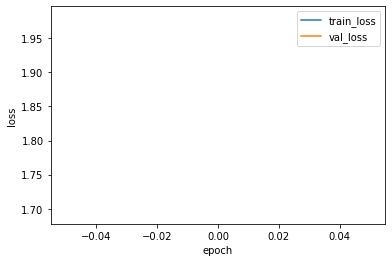

In [ ]:
plt.plot(loss_plot, label='train_loss')
plt.plot(val_loss_plot, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

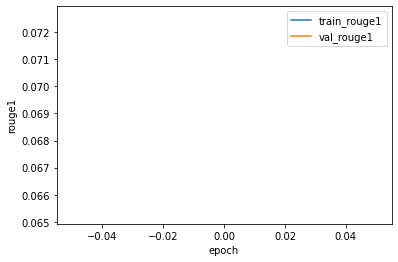

In [ ]:
plt.plot(total_rouge1_plot, label='train_rouge1')
plt.plot(total_val_rouge1_plot, label='val_rouge1')
plt.xlabel('epoch')
plt.ylabel('rouge1')
plt.legend()
plt.show()

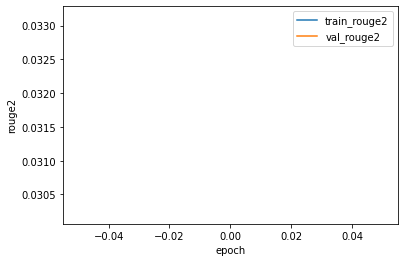

In [ ]:
plt.plot(total_rouge2_plot, label='train_rouge2')
plt.plot(total_val_rouge2_plot, label='val_rouge2')
plt.xlabel('epoch')
plt.ylabel('rouge2')
plt.legend()
plt.show()

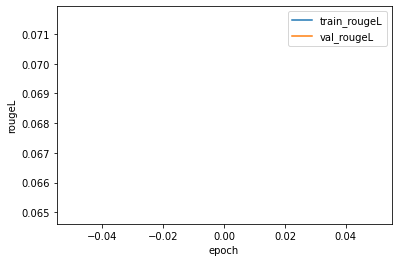

In [ ]:
plt.plot(total_rougeL_plot, label='train_rougeL')
plt.plot(total_val_rougeL_plot, label='val_rougeL')
plt.xlabel('epoch')
plt.ylabel('rougeL')
plt.legend()
plt.show()

# 평가 데이터 로드

In [19]:
with open('/content/test.jsonl', "r", encoding="utf-8") as f:
    jsonl = list(f)

test_data = []
for json_str in jsonl:
    test_data.append(json.loads(json_str))
    
submission = pd.read_csv('/content/sample_submission.csv')

In [20]:
test_data[0]

{'article_original': ['한국은행이 지난달 기준금리를 추가 인하한 영향으로 대출금리가 일제 하락했다.',
  '특히 기업대출금리는 1996년 관련 통계 집계 이후 가장 낮은 수준까지 하락했다.',
  "한국은행이 28일 발표한 '2019년 10월 중 금융기관 가중평균금리'에 따르면 신규취급액 기준 지난달 예금은행의 대출평균금리는 연 3.20%로 전월 대비 0.11%포인트 하락했다.",
  '대출금리를 기업과 가계로 나눠보면 기업대출금리 하락폭이 가팔랐다.',
  '10월 기업대출금리는 연 3.28%로 전월 대비 0.14%포인트 떨어졌다.',
  '연 3.28%는 1996년 1월 관련 통계 작성 이후 최저치다.',
  '대기업의 경우 기준이 되는 단기지표 금리의 하락 영향으로 10월 대출금리가 연 3.13%로 전월 대비 0.17%포인트 빠졌다.',
  '중소기업은 일부 은행의 저금리 대출 취급 등의 영향으로 연 3.39%로 0.11%포인트 하락했다.',
  '한은 관계자는 "지난달 기준금리가 인하되면서 단기 지표에 영향을 많이 받는 기업대출 금리도 역대 최저 수준으로 하락했다"고 설명했다.',
  '같은 기간 가계대출 금리도 하락했다.',
  '10월 가계대출 금리는 연 3.01%로 전월 대비 0.01%포인트 하락했다.',
  '같은 기간 주택담보대출 금리도 연 2.50%로 0.01%포인트 떨어졌다.',
  '가계대출 금리의 경우 기업대출에 비해 장기지표 영향을 많이 받아 하락폭은 작았다.',
  '한편 10월 중 비은행금융기관 예금금리(1년만기 정기예탁금 기준)는 모두 하락했고 대출금리(일반대출 기준)는 상호저축은행은 상승, 상호금융은 하락했다.'],
 'id': '368851881',
 'media': '아시아경제'}

## create test dataset

In [21]:
test = pd.DataFrame(columns=['id', 'context'])

for data in tqdm(test_data):
    
    id, texts = data['id'], data['article_original']

    context = ''

    for text in texts:
        context += text
    
    test.loc[id, 'id'] = id
    test.loc[id, 'context'] = context

100%|██████████| 4161/4161 [00:06<00:00, 686.67it/s]


In [22]:
test.head()

,id,context
368851881,368851881,한국은행이 지난달 기준금리를 추가 인하한 영향으로 대출금리가 일제 하락했다.특히 기...
368352503,368352503,나기복 대한민국 무공수훈자회 사무국장 / 충남 장례선양단 팀장우리 충남장례선양단 지...
363605040,363605040,"1929년 12월26일자 ‘180명 체포’ 등 3차례 보도동경주재기자, 일본정부 통..."
352052205,352052205,백주희문재인 대통령은 9일 공공분야를 중심으로 한 공정문화 확산의 중요성을 강조했다...
338689235,338689235,"5개 구장 중 4개 구장서 매진, 하루 최다 기록엔 58명 모자라2019년 프로야구..."


In [23]:
test_src = kobart_tokenizer(list(test.context), padding=True, truncation=True, max_length=500)

test_dataset = CustomDataset(test_src['input_ids'], None, 'test')
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=2, shuffle=False)

## 요약문 생성 및 제출

자연어 생성 모델을 베이스라인으로 제공하기에 장시간의 학습시간을 필요로 하여 간단한 규칙기반 요약문 생성하였습니다.

BART, GPT 등 자연어 생성 모델을 활용을 추천드리고 베이스라인은 데이터로드 부터 제출하는 과정의 용도로 참고해주시기 바랍니다.

In [55]:
def evaluate(model, tar_tokenizer, tokens):

    summary_ids = model.generate(tokens, num_beams=4, early_stopping=True)

    pred_list = [tar_tokenizer.convert_tokens_to_string(tar_tokenizer.convert_ids_to_tokens(g.to('cpu').tolist(), skip_special_tokens=True)[1:-1]) for g in summary_ids]

    return pred_list

In [56]:
tqdm_dataset = tqdm(enumerate(test_dataloader))

preds = []

model.eval()

with torch.no_grad():

    for batch, batch_item in tqdm_dataset:
        output = evaluate(model, kobart_tokenizer, batch_item['src_token'].to(device))
        preds.extend(output)

261it [07:24,  1.70s/it]


In [57]:
for data,pred in zip(test_data,preds):
    did = int(data['id'])
    idx = submission[submission['id']==did].index
    submission.loc[idx, 'summary'] = pred

In [60]:
submission

,id,summary
0,250366726,가학리 주민들 호소문 통해 입장 전달 “텅텅 빈 산업단지 두고 민
1,251994086,남송 채규선 작가가 2016 소외예술 활성화 지원사업 ‘시나브로’에 선정
2,252639804,당진서 군복무하며 인연 맺어 “당진시대는 훌륭한 지역의
3,252639915,진옥성결교회의 교인 28명이 성전 봉헌식 및 단기선
4,253427793,"‘설자리’ 전략을 통해 앞으로 당진시 청년발전기본조례를 제정, 수요"
...,...,...
4156,372705621,"교통법규 위반과 교통사고로 인한 운전면허 벌점 부과대상자, 면허"
4157,372751633,"배기성은 ""고등학교 동창 세 명을 찾아달라고 했다. 내 생에 봄날을 오"
4158,372770123,'관광관광산업 신용카드 매출 빅데이터 지역별 분석' 자료에 따르면 2018년 제주를...
4159,372779075,"박길수 기자임실군 애향장학회, 1억9,000만원 장학금 기"


In [61]:
submission.to_csv('/content/baseline.csv', index=False)